In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn. linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix,\
precision_recall_curve, f1_score,roc_curve, log_loss,SCORERS, fbeta_score, make_scorer

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Import data

In [2]:
df = pd.read_csv('Churn_Eng_Data.csv', index_col = 0)

In [3]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,New_Balance,Exited
RowNumber,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,Zero,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,Mid,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,High,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,Zero,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,High,0


Encode categorical data for analysis

In [4]:
gender = pd.get_dummies(df['Gender'], drop_first=True)
geography = pd.get_dummies(df['Geography'], drop_first=True)
new_balance = pd.get_dummies(df['New_Balance'], drop_first=True)

Split data into features and target

In [5]:
X = df.iloc[:,2:13]
y = df.iloc[:,13]

Join encoded variables to features

In [6]:
X = pd.concat([X, gender, geography, new_balance], axis=1)
X = X.drop(['Gender', 'Geography', 'Balance', 'New_Balance'], axis = 1)

In [7]:
X.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain,Mid,Zero
RowNumber,,,,,,,,,,,,
1,619,42,2,1,1,1,101348.88,0,0,0,0,1
2,608,41,1,1,0,1,112542.58,0,0,1,1,0
3,502,42,8,3,1,0,113931.57,0,0,0,0,0
4,699,39,1,2,0,0,93826.63,0,0,0,0,1
5,850,43,2,1,1,1,79084.10,0,0,1,0,0


Split data into training and testing set. Create scaled features

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=711, stratify =y)

In [9]:
Scaler = StandardScaler()

X_trainsc = Scaler.fit_transform(X_train)
X_testsc = Scaler.transform(X_test)

## Baseline Dummy Classifier

Dummy classifier where all customers are predicted to exit or churn

In [10]:
dummy_class = DummyClassifier(strategy = 'constant', constant = 1)
dummy_class.fit(X_trainsc, y_train)

dummy_train_score =dummy_class.score(X_trainsc,y_train)
dummy_test_score = dummy_class.score(X_testsc, y_test)

print("Dummy Training Score: {:.2f}%".format(100*dummy_train_score))
print("Dummy Test Score: {:.2f}%".format(100*dummy_test_score))

Dummy Training Score: 20.38%
Dummy Test Score: 20.35%


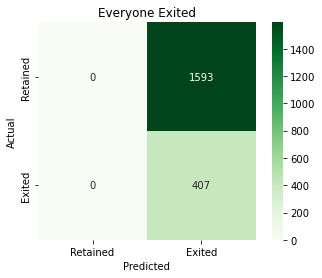

In [11]:
dummy_confusion = confusion_matrix(y_test, dummy_class.predict(X_testsc))
sns.heatmap(dummy_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Everyone Exited');
plt.savefig("Everyone_Exited.png")

Dummy classifier where all customers are predicted to be retained

In [12]:
dummy_class = DummyClassifier()
dummy_class.fit(X_trainsc, y_train)

dummy_train_score =dummy_class.score(X_trainsc,y_train)
dummy_test_score = dummy_class.score(X_testsc, y_test)

print("Dummy Training Score: {:.2f}%".format(100*dummy_train_score))
print("Dummy Test Score: {:.2f}%".format(100*dummy_test_score))

Dummy Training Score: 79.62%
Dummy Test Score: 79.65%


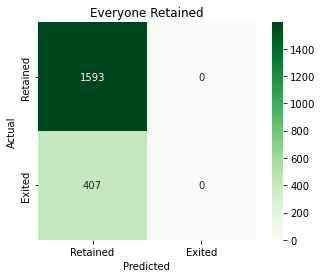

In [13]:
dummy_confusion = confusion_matrix(y_test, dummy_class.predict(X_testsc))
sns.heatmap(dummy_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Everyone Retained');
plt.savefig("Everyone_Retained.png")

ROC curve parameters

In [14]:
fpr_dum, tpr_dum, thresholds_dum = roc_curve(y_test, dummy_class.predict_proba(X_testsc)[:,1])

## K Nearest Neighbors 

**- GridSearchCV**

In [15]:
knn = KNeighborsClassifier()

Grid search parameters

In [16]:
k_range = np.arange(1,25)
weight_options = ['uniform', 'distance']
fbeta_scorer = make_scorer(fbeta_score, beta=0.25)

In [17]:
param_grid_knn = dict(n_neighbors = k_range, weights=weight_options)
print(param_grid_knn)

{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]), 'weights': ['uniform', 'distance']}


In [18]:
gridcv_knn = GridSearchCV(knn, param_grid_knn, cv=10, scoring = fbeta_scorer)
gridcv_knn.fit(X_trainsc, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(fbeta_score, beta=0.25))

In [19]:
df_cv_knn = pd.DataFrame(gridcv_knn.cv_results_)
df_cv_knn.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007545,0.000939,0.029014,0.001097,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.409176,0.466717,0.496599,0.484911,0.488140,0.470280,0.504950,0.427315,0.510865,0.473891,0.473284,0.030968,46
1,0.007070,0.000028,0.018265,0.000333,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.409176,0.466717,0.496599,0.484911,0.488140,0.470280,0.504950,0.427315,0.510865,0.473891,0.473284,0.030968,46
2,0.007626,0.001219,0.035185,0.000832,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.506775,0.626062,0.612463,0.616744,0.570470,0.621779,0.577904,0.594536,0.632558,0.537313,0.589660,0.039485,41
3,0.007201,0.000083,0.025087,0.000571,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.409176,0.466717,0.496599,0.484911,0.488140,0.470280,0.504950,0.427315,0.510865,0.473891,0.473284,0.030968,46
4,0.007119,0.000056,0.039854,0.000630,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.514915,0.608696,0.555102,0.535203,0.517042,0.551351,0.566367,0.512427,0.520096,0.578559,0.545976,0.030392,44


Plotting mean test score with distance versus number of neighbors

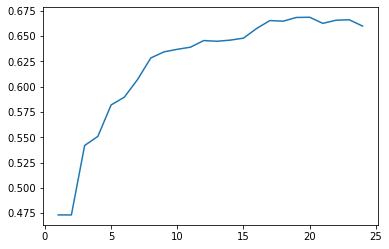

In [20]:
y_distance = df_cv_knn[df_cv_knn['param_weights'] == 'distance']['mean_test_score']
x = k_range
plt.plot(x, y_distance)

Plotting mean test score with uniform versus number of neighbors

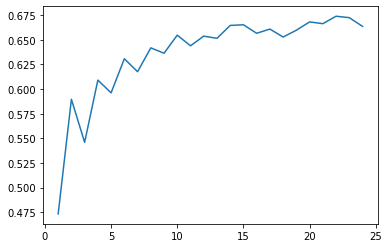

In [21]:
y_uniform = df_cv_knn[df_cv_knn['param_weights'] == 'uniform']['mean_test_score']
x = k_range
plt.plot(x, y_uniform)

In [22]:
print("Best params: ", gridcv_knn.best_params_)
print("Best estimator: ", gridcv_knn.best_estimator_)
print("Best score: ", gridcv_knn.best_score_)

Best params:  {'n_neighbors': 22, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier(n_neighbors=22)
Best score:  0.6739550835052677


Fit a new KNN model using the best parameters from the grid search

In [23]:
knn = KNeighborsClassifier(n_neighbors = gridcv_knn.best_params_['n_neighbors'], weights = gridcv_knn.best_params_['weights'])
knn.fit(X_trainsc, y_train)

KNeighborsClassifier(n_neighbors=22)

In [24]:
knn_train_score = knn.score(X_trainsc, y_train)
knn_test_score = knn.score(X_testsc, y_test)
print("KNN Training Score: {:.2f}%".format(100*knn_train_score))
print("KNN Validation Score: {:.2f}%".format(100*knn_test_score))

KNN Training Score: 83.70%
KNN Validation Score: 82.45%


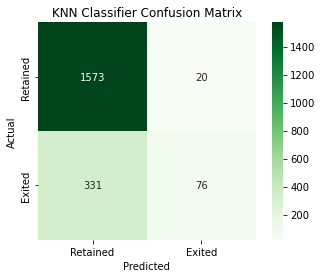

In [25]:
knn_confusion = confusion_matrix(y_test, knn.predict(X_testsc))
sns.heatmap(knn_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Classifier Confusion Matrix');
plt.savefig('KNN_Confusion.png')

In [26]:
knn_fbeta = fbeta_score(y_test, knn.predict(X_testsc), beta=0.25)
knn_precision = precision_score(y_test, knn.predict(X_testsc))
knn_recall = recall_score(y_test, knn.predict(X_testsc))
print("KNN F-Beta:{:.3f} KNN Precision:{:.3f} KNN Recall:{:.3f}".format(knn_fbeta, knn_precision, knn_recall))

KNN F-Beta:0.665 KNN Precision:0.792 KNN Recall:0.187


ROC curve parameters

In [27]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn.predict_proba(X_testsc)[:,1])

## Logistic Regression

Grid search parameters

In [28]:
C_range = np.arange(.4,.7,0.01)
param_grid_lr = dict(C = C_range, penalty = ["l1","l2"],  solver = ['lbfgs', 'liblinear', 'sag', 'saga'])

In [29]:
gridcv_lr = GridSearchCV(LogisticRegression(max_iter=100), param_grid_lr, cv=10, scoring = 'accuracy')
gridcv_lr.fit(X_trainsc, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61,
       0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga']},
             scoring='accuracy')

In [30]:
df_cv_lr = pd.DataFrame(gridcv_lr.cv_results_)
df_cv_lr.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000458,0.000042,0.000000,0.000000,0.4,l1,lbfgs,"{'C': 0.4, 'penalty': 'l1', 'solver': 'lbfgs'}",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240
1,0.008727,0.000725,0.000456,0.000463,0.4,l1,liblinear,"{'C': 0.4, 'penalty': 'l1', 'solver': 'libline...",0.8100,0.80750,...,0.82000,0.81500,0.80875,0.82375,0.80125,0.7975,0.8175,0.812500,0.008588,143
2,0.000425,0.000017,0.000000,0.000000,0.4,l1,sag,"{'C': 0.4, 'penalty': 'l1', 'solver': 'sag'}",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184
3,0.035778,0.001819,0.000513,0.000712,0.4,l1,saga,"{'C': 0.4, 'penalty': 'l1', 'solver': 'saga'}",0.8125,0.80750,...,0.82000,0.81500,0.80875,0.82375,0.80125,0.7975,0.8175,0.812750,0.008548,47
4,0.007576,0.004133,0.000296,0.000091,0.4,l2,lbfgs,"{'C': 0.4, 'penalty': 'l2', 'solver': 'lbfgs'}",0.8100,0.80875,...,0.82125,0.81625,0.80875,0.82375,0.80125,0.7975,0.8175,0.812875,0.008679,8


In [31]:
print("Best params: ", gridcv_lr.best_params_)
print("Best estimator: ", gridcv_lr.best_estimator_)
print("Best score: ", gridcv_lr.best_score_)

Best params:  {'C': 0.6400000000000002, 'penalty': 'l1', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=0.6400000000000002, penalty='l1', solver='liblinear')
Best score:  0.8130000000000001


Train new logicstic regression model using the best parameters form the grid search results

In [32]:
lr = LogisticRegression(C = gridcv_lr.best_params_['C'], max_iter = 100, multi_class='auto', 
                        penalty = gridcv_lr.best_params_['penalty'], solver= gridcv_lr.best_params_['solver'])
lr.fit(X_trainsc, y_train)
print("Logistic Training Score: {:.2f}%".format(100*lr.score(X_trainsc,y_train)))
print("Logistic Validation Score: {:.2f}%".format(100*lr.score(X_testsc,y_test)))

Logistic Training Score: 81.29%
Logistic Validation Score: 80.55%


In [133]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_val) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_testsc)[:, 1] >= threshold)
    exited_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(exited_confusion, cmap="Greens", annot=True, square=True, fmt='d',
           xticklabels=['Retained', 'Exited'],
           yticklabels=['Retained', 'Exited']);
    plt.title('Logistic Regression Confusion Matrix');
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

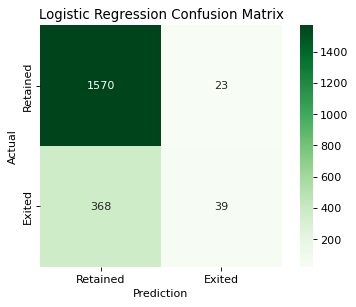

In [134]:
make_confusion_matrix(lr,max_precis.iloc[0,0])
plt.savefig('LR_Confusion.png')

Precision and recall curve versus the probability threshold

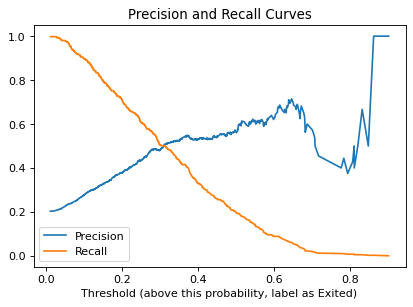

In [35]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lr.predict_proba(X_testsc)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='Precision')
plt.plot(threshold_curve, recall_curve[1:], label='Recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Exited)');
plt.title('Precision and Recall Curves');

Precision versus recall curve

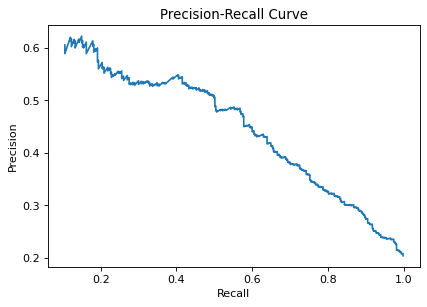

In [36]:
plt.figure(dpi=80)
plt.plot(recall_curve[10:1930], precision_curve[10:1930],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

Logistic regression features and coeficients showing feature importance 

In [132]:
col = pd.Series(X.columns)
coef_df = pd.DataFrame(lr.coef_.reshape(-1,1), columns=['Coefficients'])
coef_df = pd.concat([coef_df,col], axis=1)
coef_df = coef_df.rename({0:"Features"}, axis =1)
coef_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
1,0.751085,Age
8,0.336290,Germany
6,0.032484,EstimatedSalary
9,0.019233,Spain
4,-0.005713,HasCrCard
10,-0.026585,Mid
3,-0.026866,NumOfProducts
2,-0.044067,Tenure
0,-0.080105,CreditScore
11,-0.177244,Zero


ROC curve parameters

In [45]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr.predict_proba(X_testsc)[:,1])

## Decision Tree

Grid search parameters for basic decision tree

In [46]:
dc_range = np.arange(2,30)
param_grid_dc = dict(max_depth = dc_range, min_samples_split = range(2,15))
fbeta_scorer = make_scorer(fbeta_score, beta=0.25)

In [47]:
gridcv_dc = GridSearchCV(DecisionTreeClassifier(random_state=711), param_grid_dc, cv=10, scoring = 'precision')
gridcv_dc.fit(X_trainsc, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=711),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'min_samples_split': range(2, 15)},
             scoring='precision')

In [48]:
print("Best params: ", gridcv_dc.best_params_)
print("Best estimator: ", gridcv_dc.best_estimator_)
print("Best score: ", gridcv_dc.best_score_)

Best params:  {'max_depth': 3, 'min_samples_split': 2}
Best estimator:  DecisionTreeClassifier(max_depth=3, random_state=711)
Best score:  0.863554537417804


Train a Decision Tree model with the best model parameters form the grid search

In [49]:
dc = DecisionTreeClassifier(max_depth = gridcv_dc.best_params_['max_depth'],
                            min_samples_split=gridcv_dc.best_params_['min_samples_split'], random_state = 711)
dc.fit(X_trainsc, y_train)
dc_train_score = dc.score(X_trainsc, y_train)
dc_test_score = dc.score(X_testsc,y_test)
print("DC Training Score: {:.2f}%".format(100*dc_train_score))
print("DC Test Score: {:.2f}%".format(100*dc_test_score))

DC Training Score: 84.25%
DC Test Score: 82.95%


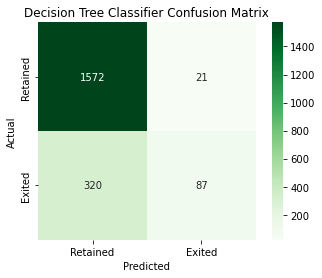

In [50]:
dc_confusion = confusion_matrix(y_test, dc.predict(X_testsc))
sns.heatmap(dc_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Classifier Confusion Matrix');
plt.savefig('DC_Confusion.png')

In [51]:
dc_fbeta = fbeta_score(y_test, dc.predict(X_testsc), beta=0.25)
dc_precision = precision_score(y_test, dc.predict(X_testsc))
dc_recall = recall_score(y_test, dc.predict(X_testsc))
print("DC F-Beta:{:.3f} DC Precision:{:.3f} DC Recall:{:.3f}".format(dc_fbeta, dc_precision, dc_recall))

DC F-Beta:0.693 DC Precision:0.806 DC Recall:0.214


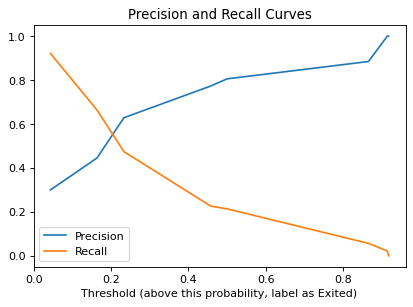

In [131]:
precision_curve_dc, recall_curve_dc, threshold_curve_dc = precision_recall_curve(y_test, dc.predict_proba(X_testsc)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve_dc, precision_curve_dc[1:],label='Precision')
plt.plot(threshold_curve_dc, recall_curve_dc[1:], label='Recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Exited)');
plt.title('Precision and Recall Curves');

Descision Tree features and coeficients showing feature importance

In [53]:
col = pd.Series(X.columns)
coef_df = pd.DataFrame(dc.feature_importances_.reshape(-1,1), columns=['Coefficients'])
coef_df = pd.concat([coef_df,col], axis=1)
coef_df = coef_df.rename({0:"Features"}, axis =1)
coef_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
1,0.514437,Age
3,0.294078,NumOfProducts
5,0.176170,IsActiveMember
11,0.015315,Zero
0,0.000000,CreditScore
2,0.000000,Tenure
4,0.000000,HasCrCard
6,0.000000,EstimatedSalary
7,0.000000,Male
8,0.000000,Germany


ROC curve parameters

In [130]:
fpr_dc, tpr_dc, thresholds_dc = roc_curve(y_test, dc.predict_proba(X_testsc)[:,1])

## Random Forest

Random forest grid search parameters

In [55]:
rf_range = np.arange(1,40)
md_range = np.arange(2,15)
param_grid_rf = dict(n_estimators = rf_range, max_depth=md_range)
fbeta_scorer = make_scorer(fbeta_score, beta=0.25)

In [56]:
gridcv_rf = GridSearchCV(RandomForestClassifier(random_state=711), param_grid_rf, cv=5, scoring = fbeta_scorer)
gridcv_rf.fit(X_trainsc, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=711),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])},
             scoring=make_scorer(fbeta_score, beta=0.25))

In [57]:
print("Best params: ", gridcv_rf.best_params_)
print("Best estimator: ", gridcv_rf.best_estimator_)
print("Best score: ", gridcv_rf.best_score_)

Best params:  {'max_depth': 5, 'n_estimators': 28}
Best estimator:  RandomForestClassifier(max_depth=5, n_estimators=28, random_state=711)
Best score:  0.8012472650759366


Train a Random Forest model with the best parameters from the grid search

In [58]:
rf = RandomForestClassifier(n_estimators=gridcv_rf.best_params_['n_estimators'],max_depth =gridcv_rf.best_params_['max_depth'], random_state=711)
rf.fit(X_trainsc, y_train)

rf_train_score = rf.score(X_trainsc, y_train)
rf_test_score = rf.score(X_testsc,y_test)
print("RF Training Score: {:.2f}%".format(100*rf_train_score))
print("RF Test Score: {:.2f}%".format(100*rf_test_score))

RF Training Score: 85.56%
RF Test Score: 83.70%


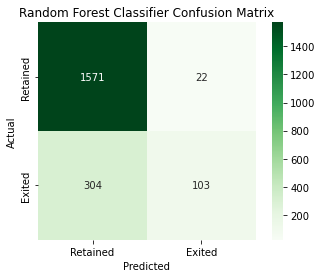

In [59]:
rf_confusion = confusion_matrix(y_test, rf.predict(X_testsc))
sns.heatmap(rf_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Classifier Confusion Matrix');
plt.savefig('RF_Confusion.png')

In [60]:
rf_fbeta = fbeta_score(y_test, rf.predict(X_testsc), beta=0.25)
rf_precision = precision_score(y_test, rf.predict(X_testsc))
rf_recall = recall_score(y_test, rf.predict(X_testsc))
print("RF F-Beta:{:.3f} RF Precision:{:.3f} RF Recall:{:.3f}".format(rf_fbeta, rf_precision, rf_recall))

RF F-Beta:0.727 RF Precision:0.824 RF Recall:0.253


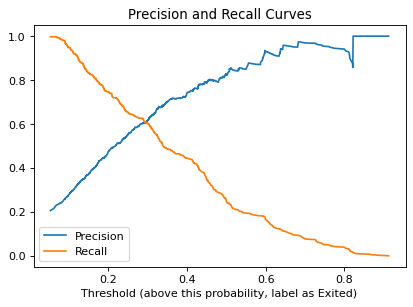

In [129]:
precision_curve_rf, recall_curve_rf, threshold_curve_rf = precision_recall_curve(y_test, rf.predict_proba(X_testsc)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve_rf, precision_curve_rf[1:],label='Precision')
plt.plot(threshold_curve_rf, recall_curve_rf[1:], label='Recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Exited)');
plt.title('Precision and Recall Curves');

Random Forest features and coeficients showing feature importance

In [62]:
col = pd.Series(X.columns)
coef_df = pd.DataFrame(rf.feature_importances_.reshape(-1,1), columns=['Coefficients'])
coef_df = pd.concat([coef_df,col], axis=1)
coef_df = coef_df.rename({0:"Features"}, axis =1)
coef_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
1,0.420250,Age
3,0.333974,NumOfProducts
5,0.082613,IsActiveMember
8,0.069595,Germany
0,0.024544,CreditScore
11,0.023639,Zero
7,0.016638,Male
6,0.013875,EstimatedSalary
2,0.005854,Tenure
9,0.003768,Spain


ROC curve parameters

In [128]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_testsc)[:,1])

## XGBOOST

In [65]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV

In [66]:
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='auc')

In [67]:
xgb.fit(X_trainsc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [68]:
xgb_train_score = xgb.score(X_trainsc, y_train)
xgb_test_score = xgb.score(X_testsc,y_test)
print("RF Training Score: {:.2f}%".format(100*xgb_train_score))
print("RF Test Score: {:.2f}%".format(100*xgb_test_score))

RF Training Score: 94.39%
RF Test Score: 85.15%


In [70]:
params = {
    "max_depth": [2, 3, 4, 5, 6, 8, 10, 12, 15],
    "learning_rate": [0.5, 0.10, 0.15, 0.20, 0.25, 0.30],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}



In [116]:
random_cv = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='accuracy', n_jobs=1, cv=5, verbose=1)



In [117]:
random_cv.fit(X_trainsc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='auc', gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=1...
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weight=1, subs

In [118]:
print("Best params: ", random_cv.best_params_)
print("Best estimator: ", random_cv.best_estimator_)
print("Best score: ", random_cv.best_score_)

Best params:  {'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.0, 'colsample_bytree': 0.4}
Best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eval_metric='auc',
              gamma=0.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=4, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
Best score:  0.863875


In [120]:
xgb_class = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eval_metric='auc',
              gamma=0.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=4, min_child_weight=5, 
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [121]:
xgb_class.fit(X_trainsc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eval_metric='auc',
              gamma=0.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=4, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [122]:
xgb_train_score = xgb_class.score(X_trainsc, y_train)
xgb_test_score = xgb_class.score(X_testsc,y_test)
print("RF Training Score: {:.2f}%".format(100*xgb_train_score))
print("RF Test Score: {:.2f}%".format(100*xgb_test_score))

RF Training Score: 87.66%
RF Test Score: 85.65%


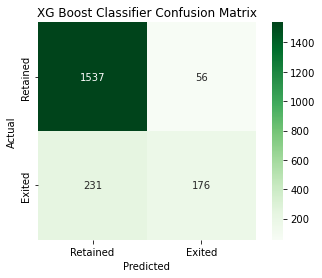

In [123]:
xgb_confusion = confusion_matrix(y_test, xgb_class.predict(X_testsc))
sns.heatmap(xgb_confusion, cmap="Greens", annot=True, square=True,fmt='g', 
            xticklabels=['Retained', 'Exited'], 
            yticklabels=['Retained', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XG Boost Classifier Confusion Matrix');
plt.savefig('XGB_Confusion.png')

In [124]:
xgb_fbeta = fbeta_score(y_test, xgb_class.predict(X_testsc), beta=1)
xgb_precision = precision_score(y_test, xgb_class.predict(X_testsc))
xgb_recall = recall_score(y_test, xgb_class.predict(X_testsc))
print("XGB F Beta:{:.3f} XGB Precision:{:.3f} XGB Recall:{:.3f}".format(xgb_fbeta,xgb_precision,xgb_recall))

XGB F Beta:0.551 XGB Precision:0.759 XGB Recall:0.432


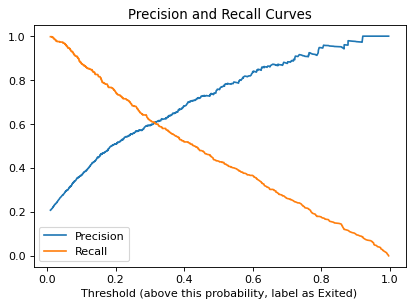

In [125]:
precision_curve_xgb, recall_curve_xgb, threshold_curve_xgb = precision_recall_curve(y_test, xgb_class.predict_proba(X_testsc)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve_xgb, precision_curve_xgb[1:],label='Precision')
plt.plot(threshold_curve_xgb, recall_curve_xgb[1:], label='Recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Exited)');
plt.title('Precision and Recall Curves');

XG Boost features and coeficients showing feature importance

In [126]:
col = pd.Series(X.columns)
coef_df = pd.DataFrame(xgb_class.feature_importances_.reshape(-1,1), columns=['Coefficients'])
coef_df = pd.concat([coef_df,col], axis=1)
coef_df = coef_df.rename({0:"Features"}, axis =1)
coef_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
3,0.382432,NumOfProducts
1,0.173112,Age
5,0.114730,IsActiveMember
8,0.096228,Germany
11,0.073141,Zero
7,0.056143,Male
0,0.023605,CreditScore
6,0.022113,EstimatedSalary
9,0.018823,Spain
2,0.016951,Tenure


ROC curve parameters

In [111]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_class.predict_proba(X_testsc)[:,1])

## ROC Curve for Banking Churn

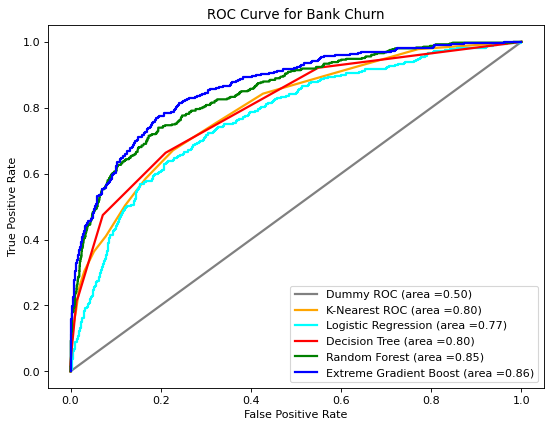

In [109]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(fpr_dum, tpr_dum,lw=2, c= 'gray',label = "Dummy ROC (area ={:.2f})".format(roc_auc_score(y_test, dummy_class.predict_proba(X_testsc)[:,1])))
plt.plot(fpr_knn, tpr_knn,lw=2, c='orange', label = "K-Nearest ROC (area ={:.2f})".format(roc_auc_score(y_test, knn.predict_proba(X_testsc)[:,1])))
plt.plot(fpr_lr, tpr_lr,lw=2, c='cyan',label = "Logistic Regression (area ={:.2f})".format(roc_auc_score(y_test, lr.predict_proba(X_testsc)[:,1])))
plt.plot(fpr_dc, tpr_dc,lw=2, c='red', label = "Decision Tree (area ={:.2f})".format(roc_auc_score(y_test, dc.predict_proba(X_testsc)[:,1])))
plt.plot(fpr_rf, tpr_rf,lw=2, c='green',label = "Random Forest (area ={:.2f})".format(roc_auc_score(y_test, rf.predict_proba(X_testsc)[:,1])))
plt.plot(fpr_xgb, tpr_xgb,lw=2, c='blue',label = "Extreme Gradient Boost (area ={:.2f})".format(roc_auc_score(y_test, xgb_class.predict_proba(X_testsc)[:,1])))
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Bank Churn');
plt.legend(loc='lower right')
plt.savefig("ROC Curve.png")

In [110]:
print("Log-loss on dummy: {:6.4f}".format(log_loss(y_test, dummy_class.predict_proba(X_testsc))))
print("Log-loss on knn: {:6.4f}".format(log_loss(y_test, knn.predict_proba(X_testsc))))
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, lr.predict_proba(X_testsc))))
print("Log-loss on dc: {:6.4f}".format(log_loss(y_test, dc.predict_proba(X_testsc))))
print("Log-loss on rf: {:6.4f}".format(log_loss(y_test, rf.predict_proba(X_testsc))))
print("Log-loss on xgb: {:6.4f}".format(log_loss(y_test, xgb_class.predict_proba(X_testsc))))

Log-loss on dummy: 0.5052
Log-loss on knn: 0.5401
Log-loss on logit: 0.4280
Log-loss on dc: 0.3921
Log-loss on rf: 0.3748
Log-loss on xgb: 0.3403


## Thresholding Analysis

Merge balance and customerid back to the partitioned test data for analysis

In [138]:
X_test_result = X_test.reset_index()
X_test_result = X_test_result.merge(df[['Balance','CustomerId']], how='left', left_on="RowNumber", right_on="RowNumber")

Concatnate the predicted probabilities from the XGboost model to the test results

In [139]:
xgb_pred = pd.Series(xgb_class.predict_proba(X_testsc)[:,1], name='Pred')
X_test_result = pd.concat([X_test_result,xgb_pred],axis=1, ignore_index = False)

Merge the target variable back with the test data

In [140]:
X_test_result = X_test_result.merge(y_test, how='left', left_on="RowNumber", right_on="RowNumber")

Bin the test results in probability ranges based of the resultant predicted probabilites

In [144]:
bins = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
X_test_result['binned'] = pd.cut(X_test_result['Pred'], bins)
X_test_result.head()

,RowNumber,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain,Mid,Zero,Balance,CustomerId,Pred,Exited,binned
0,4440,613,21,7,1,1,1,36560.51,0,0,0,1,0,105627.95,15696539,0.034348,0,"(0.0, 0.1]"
1,1372,611,43,8,1,1,0,114996.33,0,0,0,1,0,64897.75,15792722,0.397863,0,"(0.3, 0.4]"
2,5600,579,50,5,1,0,1,192146.63,0,1,0,1,0,117721.02,15635870,0.809166,1,"(0.8, 0.9]"
3,5313,712,48,8,2,1,0,183235.33,0,0,1,0,1,0.00,15726178,0.154138,0,"(0.1, 0.2]"
4,8755,776,43,4,2,0,1,162137.50,0,0,0,0,1,0.00,15619045,0.074827,0,"(0.0, 0.1]"


Structure data for Predicted Probability vs. Event Rate by Probability Decile chart

In [135]:
Event_Rate= X_test_res.groupby('binned',as_index=False)['Exited'].mean() #Percent of postitive class
Avg_Prob = X_test_res.groupby('binned', as_index=False)['Pred'].mean()  #Average Predicted Probability
Event_Rate.iloc[:,1]

0    0.043732
1    0.155440
2    0.306452
3    0.388889
4    0.434783
5    0.617021
6    0.609756
7    0.844444
8    0.837838
9    0.961538
Name: Exited, dtype: float64

In [136]:
Avg_Prob.iloc[:,1]

0    0.047747
1    0.144220
2    0.248879
3    0.349902
4    0.452018
5    0.553816
6    0.649263
7    0.744031
8    0.854457
9    0.956892
Name: Pred, dtype: float32

Investigate customers with high probability to churn and large account balances

In [141]:
X_result = X_test_result[X_test_result['Pred']>0.9].sort_values(['Pred','Balance'], ascending = False)

In [142]:
X_result.head()

,RowNumber,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain,Mid,Zero,Balance,CustomerId,Pred,Exited
74,2615,546,58,3,4,1,0,128881.87,0,1,0,1,0,106458.31,15640846,0.995631,1
407,6832,469,52,8,3,0,0,150093.32,0,1,0,0,0,139493.25,15696989,0.994855,1
1893,6256,547,55,4,3,1,0,16922.28,1,1,0,1,0,111362.76,15589017,0.993642,1
1164,1006,521,52,5,3,0,0,53793.10,1,1,0,1,0,116497.31,15701602,0.992429,1
1754,7534,630,51,0,3,0,0,88372.69,0,1,0,1,0,108449.23,15592773,0.990982,1


## Cost Modeling

Using the baseline confusion matrix a cost can be associated with either approach. Assume everyone churns or assume no one churns. It is assumed that there is a $150 cost to retain a customer that is predicted to churn (True Positives+False Positives) and $750 to acquire a new customer (False Negatives). Additionally, True Postives are considered to have a saving of $750 because a customer is successfully retained.

In [145]:
#Assume everyone churns

new_pred_ones = np.ones(shape=(2000,))

conf = confusion_matrix(y_test, new_pred_ones)

total_cost = (conf[0,1] * 150) + (conf[1,1] * 150) + conf[1,0] * 750
total_savings = conf[1,1] * 750

net_gain = total_savings - total_cost
print(net_gain)

conf

5250


array([[   0, 1593],
       [   0,  407]])

In [96]:
#Assume no one churns

new_pred_zeros = np.zeros(shape=(2000,))

conf = confusion_matrix(y_test, new_pred_zeros)

total_cost = (conf[0,1] * 150) + (conf[1,1] * 150) + conf[1,0] * 750
total_savings = conf[1,1] * 750

net_gain = total_savings - total_cost
print(net_gain)

conf


-305250


array([[1593,    0],
       [ 407,    0]])

Every classification model is sent into the function below and a cost is associated with every probability threshold. A max saving can be found to determine the best classification model.

In [97]:
def model_cost(model):

    savings = []
    idx = []
    for i in np.arange(0,1,0.01):
        y_predict = (model.predict_proba(X_testsc)[:, 1] >= i)
        cf_matrix = confusion_matrix(y_test, y_predict)
        total_cost = (cf_matrix[0][1] * 150) + (cf_matrix[1][1] * 150) + cf_matrix[1][0] * 750
        total_savings = cf_matrix[1][1] * 750
        savings.append(total_savings - total_cost)
        idx.append(i)

    print('Max savings = {:d}'.format(max(savings)))
    return (savings,idx)

In [146]:
#Baseline Model
dum_savings,dum_idx = model_cost(dummy_class)

Max savings = 5250


In [147]:
#K-nearest
knn_savings,knn_idx = model_cost(knn)

Max savings = 55800


In [100]:
#Logistic Regression
lr_savings,lr_idx = model_cost(lr)

Max savings = 48450


In [101]:
#Decision Tree
dc_savings,dc_idx = model_cost(dc)

Max savings = 69750


In [102]:
#Random Forest
rf_savings,rf_idx = model_cost(rf)

Max savings = 77700


In [103]:
#XG Boost
xgb_savings,xgb_idx = model_cost(xgb_class)

Max savings = 92100


Threshold of the max saving of the XG Boost model

In [150]:
res_list = list(zip(xgb_savings,xgb_idx))
res_df = pd.DataFrame(res_list, columns =['saving/loss', 'thresh'])
res_df[res_df['saving/loss']==max(res_df['saving/loss'])]

,saving/loss,thresh
10,92100,0.1


In [105]:
def make_confusion_matrix(model, threshold=0.1):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_val) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_testsc)[:, 1] >= threshold)
    exited_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(exited_confusion, cmap="Greens", annot=True, square=True, fmt='d',
           xticklabels=['Retained', 'Exited'],
           yticklabels=['Retained', 'Exited']);
    plt.title('XG Boost Confusion Matrix');
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

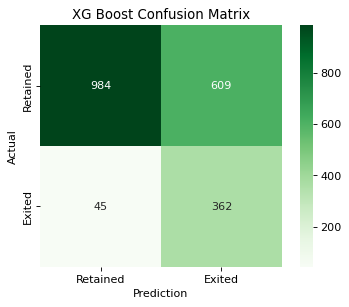

In [106]:
make_confusion_matrix(xgb_class)

Cost analysis of each model showing the saving or loss versus the probability threshold. To maximize savings the XG Boost model at a threshold of 10% will yeild the highest saving.

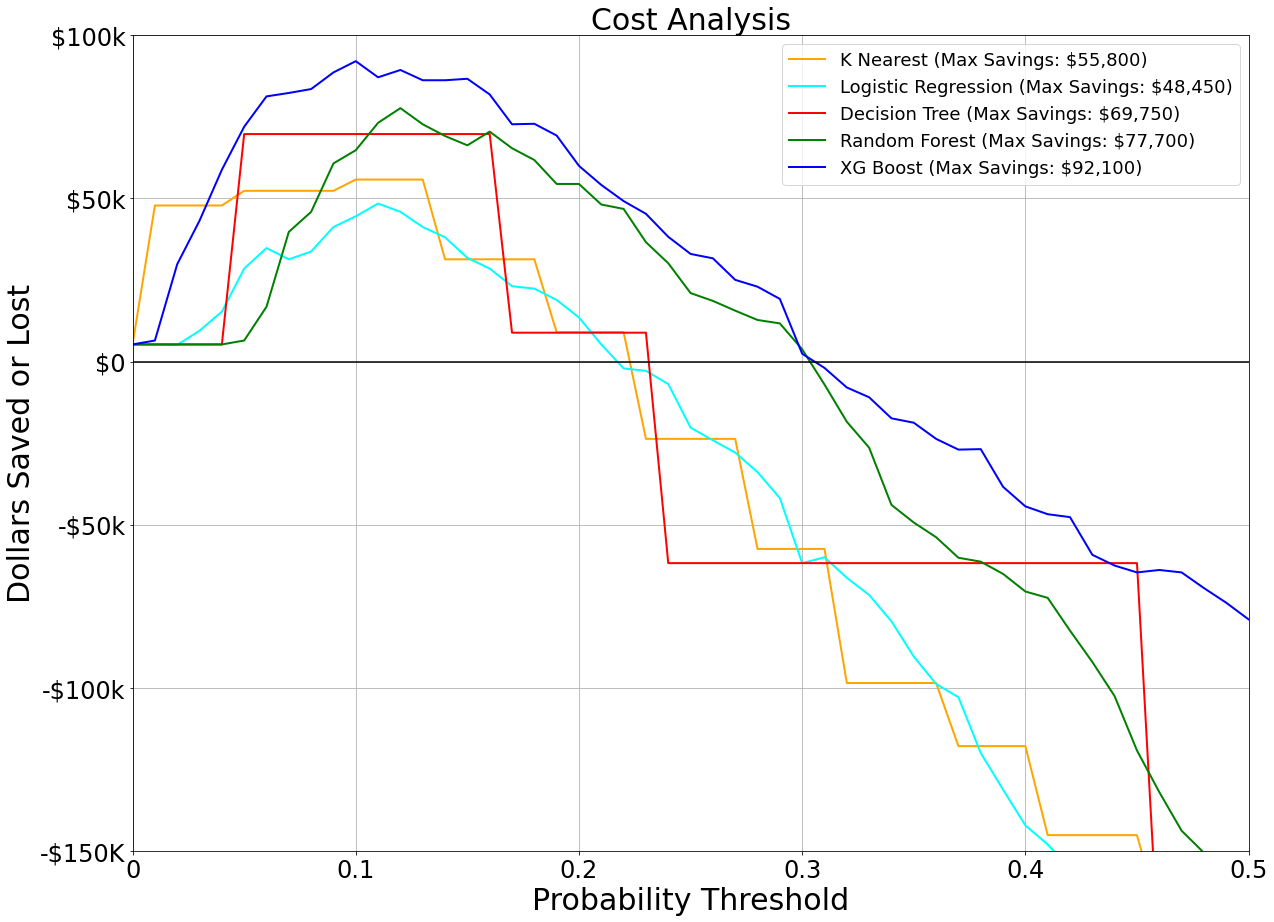

In [108]:
fig, ax = plt.subplots(figsize=(20, 15))
# plt.plot(dum_idx, dum_gains, label='Logistic Regression', color='purple', lw=2)
plt.plot(knn_idx, knn_savings, label='K Nearest (Max Savings: ${:,})'.format(max(knn_savings)), color='orange', lw=2)
plt.plot(lr_idx, lr_savings, label='Logistic Regression (Max Savings: ${:,})'.format(max(lr_savings)), color='cyan', lw=2)
plt.plot(dc_idx, dc_savings, label='Decision Tree (Max Savings: ${:,})'.format(max(dc_savings)), color='red', lw=2)
plt.plot(rf_idx, rf_savings, label='Random Forest (Max Savings: ${:,})'.format(max(rf_savings)), color='green', lw=2)
plt.plot(xgb_idx, xgb_savings, label='XG Boost (Max Savings: ${:,})'.format(max(xgb_savings)), color='blue', lw=2)
ax.axhline(y=0, color='black')
plt.grid()
ax.set_xbound(lower=0, upper=0.5)
ax.set_ybound(lower=-150000, upper=100000)
ax.set_yticklabels( ['-$150K','-$100k','-$50k', '$0', '$50k', '$100k'], fontsize=24)
ax.set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5'], fontsize=24)
plt.xlabel('Probability Threshold', fontsize=30)
plt.ylabel('Dollars Saved or Lost',fontsize=30)
plt.legend(fontsize=18)
plt.title('Cost Analysis',fontsize=30);
plt.savefig('Cost_Analysis.png')